In [32]:
import os
fullpth = os.path.abspath(os.path.curdir)
while os.path.basename(os.path.abspath(os.path.curdir)) != 'multi-instance-mask-rcnn-extension':
    %cd ../

# %cd code/multi-instance-mask-rcnn-extension/

In [33]:
from multimaskextension.analysis import pdanalysis

In [34]:

import os
from glob import glob
import pickle
import pandas as pd
import numpy as np
from pprint import pprint
import yaml
from itertools import chain
import yaml
from bokeh.io import output_file, show, output_notebook
from bokeh.palettes import Spectral5, Turbo256
from bokeh import palettes
from bokeh.plotting import figure
from bokeh.transform import factor_cmap
from bokeh.models.widgets import Tabs, Panel
from bokeh.models import FactorRange
from bokeh.layouts import column, row
from bokeh.io import export_png

from multimaskextension.analysis.pdanalysis import get_datetime, findDiff, get_value_from_cfg, \
    logdirs_to_df, inplace_augment_df_with_cfg_columns
from multimaskextension.analysis.bokehutils import grouped_bar, get_blank_figure
from bokeh.io import show
from bokeh.models import ColumnDataSource, FactorRange
from bokeh.plotting import figure

# MULTIMASKROOT = "/home/adelgior/afs_directories/kalman/code/multi-instance-mask-rcnn-extension"
MULTIMASKROOT = "/home/adelgior/code/multi-instance-mask-rcnn-extension"
logdir_regex = 'output/logs/test/train_2021-06*'  # -06

if not os.path.exists(MULTIMASKROOT):
    raise Exception(f"Must change MULTIMASKROOT path in {__file__}")


In [35]:
# Get log directory list
logdir_regex = os.path.join(MULTIMASKROOT, logdir_regex)
logdirs = sorted(glob(logdir_regex))
if len(logdirs) == 0:
    print(f"No log directories available in {logdir_regex}")
else:
    # Create dataframe
    df = logdirs_to_df(logdirs)

    # Add auxiliary columns
    for new_colnm, fnc in {
        'date': lambda x: get_datetime(x.trainname)[0],
        'time': lambda x: get_datetime(x.trainname)[1],
    }.items():
        if new_colnm in df:
            print(f"{new_colnm} already in df")
        df[new_colnm] = df.apply(fnc, axis=1)

    # Reformat existing columns
    for old_colnm, reformat_fcn in {
        'date': pd.to_datetime,
    }.items():
        if old_colnm in df:
            df[old_colnm] = reformat_fcn(df[old_colnm])
    print('Loading configs for comparison')
    augmented_col_to_keys = inplace_augment_df_with_cfg_columns(df)

    # Config adjustment - 'Vanilla' still says active head is custom by default
    if 'MODEL-ROI_MASK_HEAD-INIT_ACTIVATED_MASK_HEAD' in df.columns and \
            'MODEL-ROI_MASK_HEAD-NAME' in df.columns:
        df[df['MODEL-ROI_MASK_HEAD-NAME'] == 'StandardROIHeads',
           'MODEL-ROI_MASK_HEAD-INIT_ACTIVATED_MASK_HEAD'] = None

    # Generate a unique id for each experiment
    unique_id_keys = list(augmented_col_to_keys.keys()) + ['itr'] + ['date'] + \
                     ['task_name'] + ['time']
    unique_id = df.apply(lambda x: tuple(tuple((k, f"{x[k]}") for k in unique_id_keys)), axis=1)
    df['uniqueid'] = unique_id
    uniqueid_as_str = df.uniqueid.apply(lambda x: ', '.join(str(k) for k in x))
    df['uniqueid_as_str'] = uniqueid_as_str

    # Generate a train tag with the configurations
    df['traintag'] = df.apply(
        lambda x: tuple(tuple((colnm, x[colnm]) for colnm in augmented_col_to_keys.keys())),
        axis=1)
    traintag_as_str = df.traintag.apply(lambda x: ', '.join(str(k) for k in x))
    assert len(df.traintag) == len(traintag_as_str)
    df['traintag_as_str'] = traintag_as_str
print('Done')

Reading /home/adelgior/code/multi-instance-mask-rcnn-extension/output/logs/test/train_2021-06-16-103924_VCS-f165af5_MAX_ITR-100000_HEAD_TYPE-custom_MATCH-0/coco_2017_val/itr4000/results.pkl
Reading /home/adelgior/code/multi-instance-mask-rcnn-extension/output/logs/test/train_2021-06-16-103924_VCS-f165af5_MAX_ITR-100000_HEAD_TYPE-custom_MATCH-0/coco_2017_val/itr1000/results.pkl
Reading /home/adelgior/code/multi-instance-mask-rcnn-extension/output/logs/test/train_2021-06-16-103924_VCS-f165af5_MAX_ITR-100000_HEAD_TYPE-custom_MATCH-0/coco_2017_val/itr0/results.pkl
Reading /home/adelgior/code/multi-instance-mask-rcnn-extension/output/logs/test/train_2021-06-16-154242_VCS-f165af5_MAX_ITR-100000_HEAD_TYPE-custom_MATCH-0/coco_2017_val/itr16000/results.pkl
Reading /home/adelgior/code/multi-instance-mask-rcnn-extension/output/logs/test/train_2021-06-16-154242_VCS-f165af5_MAX_ITR-100000_HEAD_TYPE-custom_MATCH-0/coco_2017_val/itr64000/results.pkl
Reading /home/adelgior/code/multi-instance-mask-rcn

/home/adelgior/code/multi-instance-mask-rcnn-extension/multimaskextension/analysis/pdanalysis.py:66: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  all_cfgs = {config_file: yaml.load(open(config_file, 'rb')) for config_file in df[cf_name]}


Done


In [36]:
filters = {
    # 'MODEL-ROI_MASK_HEAD-MATCHING_LOSS': False,
    # 'SOLVER-BASE_LR': 0.02,
    'task_name': ['segm-pred_masks', 'segm-pred_masks1', 'segm-pred_masks2',
                  'segm-agg-pred_masks1_pred_masks2'],
}
for f in filters.keys():
    assert f in df, f"{f} not in df columns"

    
df_filt = df
for nm, val in filters.items():
    if type(val) is list:
        df_filt = df_filt[df_filt[nm].apply(lambda x: x in val)]
    else:
        df_filt = df_filt[df_filt[nm].apply(lambda x: x == val)]
    if len(df_filt) == 0:
        print(f"No matches for {nm} == {val}")


In [37]:
nrows = len(df)
df['cfgtag'] = list(zip(*[list(zip([k for _ in range(nrows)], df[k])) for k in augmented_col_to_keys.keys()]))
modeltag = list(zip(df.cfgtag, df.itr))
modeltasktag = list(tuple(x) for x in zip(df.cfgtag, df.itr, df.task_name))
df['modeltag_hashable'] = pd.Series(modeltag).astype('str')
df['modeltasktag_hashable'] = pd.Series(modeltasktag).astype('str')


In [38]:
df['modeltasktag_hashable'][0]


"((('DATALOADER-REPEAT_THRESHOLD', 0.02), ('DATALOADER-SAMPLER_TRAIN', 'TrainingSampler'), ('GLOBAL-NOOP', False), ('MODEL-ROI_HEADS-NAME', 'MultiROIHeadsAPD'), ('MODEL-ROI_MASK_HEAD-INIT_ACTIVATED_MASK_HEAD', 'custom'), ('MODEL-ROI_MASK_HEAD-N_MASKS_PER_ROI', 1), ('SEED', -1), ('SOLVER-IMS_PER_BATCH', 8), ('SOLVER-MAX_ITER', 100000)), 4000, 'segm-pred_masks')"

In [39]:
df[df.itr == 0]

,trainname,logdir,config_file,task_name,itr,split,AP,AP50,AP75,APs,...,SEED,SOLVER-IMS_PER_BATCH,SOLVER-MAX_ITER,uniqueid,uniqueid_as_str,traintag,traintag_as_str,cfgtag,modeltag_hashable,modeltasktag_hashable
8,train_2021-06-16-103924_VCS-f165af5_MAX_ITR-10...,/home/adelgior/code/multi-instance-mask-rcnn-e...,/home/adelgior/code/multi-instance-mask-rcnn-e...,segm-pred_masks,0,coco_2017_val,7.345143,18.311685,5.076343,3.826222,...,-1,8,100000,"((DATALOADER-REPEAT_THRESHOLD, 0.02), (DATALOA...","('DATALOADER-REPEAT_THRESHOLD', '0.02'), ('DAT...","((DATALOADER-REPEAT_THRESHOLD, 0.02), (DATALOA...","('DATALOADER-REPEAT_THRESHOLD', 0.02), ('DATAL...","((DATALOADER-REPEAT_THRESHOLD, 0.02), (DATALOA...","((('DATALOADER-REPEAT_THRESHOLD', 0.02), ('DAT...","((('DATALOADER-REPEAT_THRESHOLD', 0.02), ('DAT..."
9,train_2021-06-16-103924_VCS-f165af5_MAX_ITR-10...,/home/adelgior/code/multi-instance-mask-rcnn-e...,/home/adelgior/code/multi-instance-mask-rcnn-e...,segm-pred_masks1,0,coco_2017_val,7.345147,18.311703,5.076343,3.826224,...,-1,8,100000,"((DATALOADER-REPEAT_THRESHOLD, 0.02), (DATALOA...","('DATALOADER-REPEAT_THRESHOLD', '0.02'), ('DAT...","((DATALOADER-REPEAT_THRESHOLD, 0.02), (DATALOA...","('DATALOADER-REPEAT_THRESHOLD', 0.02), ('DATAL...","((DATALOADER-REPEAT_THRESHOLD, 0.02), (DATALOA...","((('DATALOADER-REPEAT_THRESHOLD', 0.02), ('DAT...","((('DATALOADER-REPEAT_THRESHOLD', 0.02), ('DAT..."
10,train_2021-06-16-103924_VCS-f165af5_MAX_ITR-10...,/home/adelgior/code/multi-instance-mask-rcnn-e...,/home/adelgior/code/multi-instance-mask-rcnn-e...,segm-pred_masks2,0,coco_2017_val,9.731941,19.863922,8.892144,4.846067,...,-1,8,100000,"((DATALOADER-REPEAT_THRESHOLD, 0.02), (DATALOA...","('DATALOADER-REPEAT_THRESHOLD', '0.02'), ('DAT...","((DATALOADER-REPEAT_THRESHOLD, 0.02), (DATALOA...","('DATALOADER-REPEAT_THRESHOLD', 0.02), ('DATAL...","((DATALOADER-REPEAT_THRESHOLD, 0.02), (DATALOA...","((('DATALOADER-REPEAT_THRESHOLD', 0.02), ('DAT...","((('DATALOADER-REPEAT_THRESHOLD', 0.02), ('DAT..."
11,train_2021-06-16-103924_VCS-f165af5_MAX_ITR-10...,/home/adelgior/code/multi-instance-mask-rcnn-e...,/home/adelgior/code/multi-instance-mask-rcnn-e...,segm-agg-pred_masks1_pred_masks2,0,coco_2017_val,6.187057,14.354254,4.676586,2.987192,...,-1,8,100000,"((DATALOADER-REPEAT_THRESHOLD, 0.02), (DATALOA...","('DATALOADER-REPEAT_THRESHOLD', '0.02'), ('DAT...","((DATALOADER-REPEAT_THRESHOLD, 0.02), (DATALOA...","('DATALOADER-REPEAT_THRESHOLD', 0.02), ('DATAL...","((DATALOADER-REPEAT_THRESHOLD, 0.02), (DATALOA...","((('DATALOADER-REPEAT_THRESHOLD', 0.02), ('DAT...","((('DATALOADER-REPEAT_THRESHOLD', 0.02), ('DAT..."
28,train_2021-06-16-154242_VCS-f165af5_MAX_ITR-10...,/home/adelgior/code/multi-instance-mask-rcnn-e...,/home/adelgior/code/multi-instance-mask-rcnn-e...,segm-pred_masks,0,coco_2017_val,7.923783,19.205093,5.740991,4.083679,...,-1,8,100000,"((DATALOADER-REPEAT_THRESHOLD, 0.02), (DATALOA...","('DATALOADER-REPEAT_THRESHOLD', '0.02'), ('DAT...","((DATALOADER-REPEAT_THRESHOLD, 0.02), (DATALOA...","('DATALOADER-REPEAT_THRESHOLD', 0.02), ('DATAL...","((DATALOADER-REPEAT_THRESHOLD, 0.02), (DATALOA...","((('DATALOADER-REPEAT_THRESHOLD', 0.02), ('DAT...","((('DATALOADER-REPEAT_THRESHOLD', 0.02), ('DAT..."
29,train_2021-06-16-154242_VCS-f165af5_MAX_ITR-10...,/home/adelgior/code/multi-instance-mask-rcnn-e...,/home/adelgior/code/multi-instance-mask-rcnn-e...,segm-pred_masks1,0,coco_2017_val,7.923959,19.205958,5.740997,4.083710,...,-1,8,100000,"((DATALOADER-REPEAT_THRESHOLD, 0.02), (DATALOA...","('DATALOADER-REPEAT_THRESHOLD', '0.02'), ('DAT...","((DATALOADER-REPEAT_THRESHOLD, 0.02), (DATALOA...","('DATALOADER-REPEAT_THRESHOLD', 0.02), ('DATAL...","((DATALOADER-REPEAT_THRESHOLD, 0.02), (DATALOA...","((('DATALOADER-REPEAT_THRESHOLD', 0.02), ('DAT...","((('DATALOADER-REPEAT_THRESHOLD', 0.02), ('DAT..."
30,train_2021-06-16-154242_VCS-f165af5_MAX_ITR-10...,/home/adelgior/code/multi-instance-mask-rcnn-e...,/home/adelgior/code/multi-instance-mask-rcnn-e...,segm-pr

In [40]:
df_groupby_cfg = df.groupby('modeltasktag_hashable')
df_groupby_cfg.groups

{'((('DATALOADER-REPEAT_THRESHOLD', 0.0), ('DATALOADER-SAMPLER_TRAIN', 'TrainingSampler'), ('GLOBAL-NOOP', False), ('MODEL-ROI_HEADS-NAME', 'MultiROIHeadsAPD'), ('MODEL-ROI_MASK_HEAD-INIT_ACTIVATED_MASK_HEAD', 'custom'), ('MODEL-ROI_MASK_HEAD-N_MASKS_PER_ROI', 1), ('SEED', 1), ('SOLVER-IMS_PER_BATCH', 8), ('SOLVER-MAX_ITER', 100000)), 0, 'segm-agg-pred_masks1_pred_masks2')': [151], '((('DATALOADER-REPEAT_THRESHOLD', 0.0), ('DATALOADER-SAMPLER_TRAIN', 'TrainingSampler'), ('GLOBAL-NOOP', False), ('MODEL-ROI_HEADS-NAME', 'MultiROIHeadsAPD'), ('MODEL-ROI_MASK_HEAD-INIT_ACTIVATED_MASK_HEAD', 'custom'), ('MODEL-ROI_MASK_HEAD-N_MASKS_PER_ROI', 1), ('SEED', 1), ('SOLVER-IMS_PER_BATCH', 8), ('SOLVER-MAX_ITER', 100000)), 0, 'segm-pred_masks')': [148], '((('DATALOADER-REPEAT_THRESHOLD', 0.0), ('DATALOADER-SAMPLER_TRAIN', 'TrainingSampler'), ('GLOBAL-NOOP', False), ('MODEL-ROI_HEADS-NAME', 'MultiROIHeadsAPD'), ('MODEL-ROI_MASK_HEAD-INIT_ACTIVATED_MASK_HEAD', 'custom'), ('MODEL-ROI_MASK_HEAD-N_MASK

In [41]:
# Only keep the latest experiment if there are multiples
df_groupby_cfg = df.groupby('modeltasktag_hashable')
indices_to_drop = []
for grp in df_groupby_cfg.groups:
    if len(df_groupby_cfg.get_group(grp)) == 1:
        continue
    exsamecfgs = df_groupby_cfg.get_group(grp)
    besti, bestval = exsamecfgs['AP'].argmax(), exsamecfgs['AP'].max()
    latesti, latestval = exsamecfgs['date'].argmax(), exsamecfgs['AP'].max()
    if besti != latesti and latestval != bestval:
        print(f"AP drop for latest {exsamecfgs.task_name.iloc[0]}: {bestval}-{latestval}={bestval-latestval}")
    for i, idx in enumerate(exsamecfgs.index):
        if i != latesti:
            indices_to_drop.append(idx)
df = df.drop(index=indices_to_drop)
df_groupby_cfg = df.groupby('modeltasktag_hashable')
assert all([len(x) == 1 for x in df_groupby_cfg.groups.values()])


In [42]:
if 'DATASETS-TEST' in df.columns:
    df['DATASETS-TEST'] = df['DATASETS-TEST'].apply(str)
    df['DATASETS-TEST'].unique()

In [43]:
# Playing with pivot, melt, stack
stat_cols = [c for c in list(df.columns) if 'AP' in c]
small_stat_cols = ['AP']
cfg_cols_unordered = [c for c in augmented_col_to_keys.keys()]
cfg_cols = ['DATASETS-TEST', 'MODEL-ROI_HEADS-NAME', 'MODEL-ROI_MASK_HEAD-INIT_ACTIVATED_MASK_HEAD', 'MODEL-ROI_MASK_HEAD-N_MASKS_PER_ROI', 'DATALOADER-SAMPLER_TRAIN', 'DATALOADER-REPEAT_THRESHOLD', 'MODEL-ROI_MASK_HEAD-MATCHING_LOSS', 'SOLVER-IMS_PER_BATCH', 'SOLVER-BASE_LR', 'SOLVER-MAX_ITER']
cfg_cols = [c for c in cfg_cols if c in cfg_cols_unordered] + list(set(cfg_cols_unordered) - set(cfg_cols))
# df['modeltasktag'] = list(zip(df['', df.task_name))
# multiidx = pd.MultiIndex.from_frame(df[cfg_cols])
dftbl = df.pivot(index=cfg_cols + ['itr'], values=stat_cols, columns=['task_name'])
dftbl_small = dftbl[small_stat_cols].T
dftbl = dftbl.T
dftbl_subset = dftbl.T

In [44]:
df_sorted = df

In [45]:
melted_subset = df_sorted[df_sorted['task_name'].apply(lambda x: x in ['segm-pred_masks'])]
# melted_subset = melted_subset[melted_subset['itr'].astype(int) >= 36000]
# melted_subset = melted_subset[melted_subset.apply(lambda x: int(x['itr']) >= 32000 or ('pretrained_maskrcnn' in x['trainname']), axis=1)]
# melted_subset = melted_subset[melted_subset['DATASETS-TEST'].apply(lambda x: 'coco_2017_val' in x)]


In [46]:
df_sorted

,trainname,logdir,config_file,task_name,itr,split,AP,AP50,AP75,APs,...,SEED,SOLVER-IMS_PER_BATCH,SOLVER-MAX_ITER,uniqueid,uniqueid_as_str,traintag,traintag_as_str,cfgtag,modeltag_hashable,modeltasktag_hashable
0,train_2021-06-16-103924_VCS-f165af5_MAX_ITR-10...,/home/adelgior/code/multi-instance-mask-rcnn-e...,/home/adelgior/code/multi-instance-mask-rcnn-e...,segm-pred_masks,4000,coco_2017_val,28.312368,48.525450,29.382714,13.507612,...,-1,8,100000,"((DATALOADER-REPEAT_THRESHOLD, 0.02), (DATALOA...","('DATALOADER-REPEAT_THRESHOLD', '0.02'), ('DAT...","((DATALOADER-REPEAT_THRESHOLD, 0.02), (DATALOA...","('DATALOADER-REPEAT_THRESHOLD', 0.02), ('DATAL...","((DATALOADER-REPEAT_THRESHOLD, 0.02), (DATALOA...","((('DATALOADER-REPEAT_THRESHOLD', 0.02), ('DAT...","((('DATALOADER-REPEAT_THRESHOLD', 0.02), ('DAT..."
1,train_2021-06-16-103924_VCS-f165af5_MAX_ITR-10...,/home/adelgior/code/multi-instance-mask-rcnn-e...,/home/adelgior/code/multi-instance-mask-rcnn-e...,segm-pred_masks1,4000,coco_2017_val,28.313923,48.532230,29.383211,13.507776,...,-1,8,100000,"((DATALOADER-REPEAT_THRESHOLD, 0.02), (DATALOA...","('DATALOADER-REPEAT_THRESHOLD', '0.02'), ('DAT...","((DATALOADER-REPEAT_THRESHOLD, 0.02), (DATALOA...","('DATALOADER-REPEAT_THRESHOLD', 0.02), ('DATAL...","((DATALOADER-REPEAT_THRESHOLD, 0.02), (DATALOA...","((('DATALOADER-REPEAT_THRESHOLD', 0.02), ('DAT...","((('DATALOADER-REPEAT_THRESHOLD', 0.02), ('DAT..."
2,train_2021-06-16-103924_VCS-f165af5_MAX_ITR-10...,/home/adelgior/code/multi-instance-mask-rcnn-e...,/home/adelgior/code/multi-instance-mask-rcnn-e...,segm-pred_masks2,4000,coco_2017_val,0.000000,0.000000,0.000000,0.000000,...,-1,8,100000,"((DATALOADER-REPEAT_THRESHOLD, 0.02), (DATALOA...","('DATALOADER-REPEAT_THRESHOLD', '0.02'), ('DAT...","((DATALOADER-REPEAT_THRESHOLD, 0.02), (DATALOA...","('DATALOADER-REPEAT_THRESHOLD', 0.02), ('DATAL...","((DATALOADER-REPEAT_THRESHOLD, 0.02), (DATALOA...","((('DATALOADER-REPEAT_THRESHOLD', 0.02), ('DAT...","((('DATALOADER-REPEAT_THRESHOLD', 0.02), ('DAT..."
3,train_2021-06-16-103924_VCS-f165af5_MAX_ITR-10...,/home/adelgior/code/multi-instance-mask-rcnn-e...,/home/adelgior/code/multi-instance-mask-rcnn-e...,segm-agg-pred_masks1_pred_masks2,4000,coco_2017_val,15.067082,25.584893,15.734378,2.544670,...,-1,8,100000,"((DATALOADER-REPEAT_THRESHOLD, 0.02), (DATALOA...","('DATALOADER-REPEAT_THRESHOLD', '0.02'), ('DAT...","((DATALOADER-REPEAT_THRESHOLD, 0.02), (DATALOA...","('DATALOADER-REPEAT_THRESHOLD', 0.02), ('DATAL...","((DATALOADER-REPEAT_THRESHOLD, 0.02), (DATALOA...","((('DATALOADER-REPEAT_THRESHOLD', 0.02), ('DAT...","((('DATALOADER-REPEAT_THRESHOLD', 0.02), ('DAT..."
4,train_2021-06-16-103924_VCS-f165af5_MAX_ITR-10...,/home/adelgior/code/multi-instance-mask-rcnn-e...,/home/adelgior/code/multi-instance-mask-rcnn-e...,segm-pred_masks,1000,coco_2017_val,26.260232,46.331573,26.797134,12.473001,...,-1,8,100000,"((DATALOADER-REPEAT_THRESHOLD, 0.02), (DATALOA...","('DATALOADER-REPEAT_THRESHOLD', '0.02'), ('DAT...","((DATALOADER-REPEAT_THRESHOLD, 0.02), (DATALOA...","('DATALOADER-REPEAT_THRESHOLD', 0.02), ('DATAL...","((DATALOADER-REPEAT_THRESHOLD, 0.02), (DATALOA...","((('DATALOADER-REPEAT_THRESHOLD', 0.02), ('DAT...","((('DATALOADER-REPEAT_THRESHOLD', 0.02), ('DAT..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181,train_2021-06-21-162041_VCS-375c9c4_MAX_ITR-10...,/home/adelgior/code/multi-instance-mask-rcnn-e...,/home/adelgior/code/multi-instance-mask-rcnn-e...,segm-agg-pred_masks1_pred_masks2,0,coco_2017_val,26.351665,39.990663,28.811758,10.296980,...,1,8,100000,"((DATALOADER-REPEAT_THRESHOLD, 0.01), (DATALOA...","('DATALOADER-REPEAT_THRESHOLD', '0.01'), ('DAT...","((DATALOADER-REPEAT_THRESHOLD, 0.01), (DATALOA...","('DATALOADER-REPEAT_THRESHOLD', 0.01), ('DATAL...","((DATALOADER-REPEAT_THRESHOLD, 0.01), (DATALOA...","((('DATALOADER-REPEAT_THRESHOLD', 0.01), ('DAT...","((('DATALOADER-REPEAT_THRESHOLD', 0.01), ('DAT..."
182,train_2021-06-21-162041_VCS

In [47]:
dftbl_subset.columns

MultiIndex([(           'AP',              'segm-agg-pred_masks'),
            (           'AP', 'segm-agg-pred_masks1_pred_masks2'),
            (           'AP',                  'segm-pred_masks'),
            (           'AP',                 'segm-pred_masks1'),
            (           'AP',                 'segm-pred_masks2'),
            (         'AP50',              'segm-agg-pred_masks'),
            (         'AP50', 'segm-agg-pred_masks1_pred_masks2'),
            (         'AP50',                  'segm-pred_masks'),
            (         'AP50',                 'segm-pred_masks1'),
            (         'AP50',                 'segm-pred_masks2'),
            ...
            ('AP-hair drier',              'segm-agg-pred_masks'),
            ('AP-hair drier', 'segm-agg-pred_masks1_pred_masks2'),
            ('AP-hair drier',                  'segm-pred_masks'),
            ('AP-hair drier',                 'segm-pred_masks1'),
            ('AP-hair drier',                 

In [48]:
melted_subset = df_sorted[df_sorted['task_name'].apply(lambda x: x in ['segm-pred_masks'])]
# melted_subset = melted_subset[melted_subset['itr'].astype(int) >= 36000]
# melted_subset = melted_subset[melted_subset.apply(lambda x: int(x['itr']) == 0, axis=1)]
# melted_subset = melted_subset[melted_subset['DATASETS-TEST'].apply(lambda x: 'coco_2017_val' in x)]
dftbl = melted_subset.pivot(index=cfg_cols + ['itr'], values=stat_cols, columns=['task_name'])


In [49]:
bgcolor = 'yellow' # "#ff33aa"
def highlight_max(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_max = s == s.max()
    return [f"background-color: {bgcolor}" if v else '' for v in is_max]

dftbl_subset = dftbl
dftbl_subset.style.apply(highlight_max)


In [63]:
# baseline_index = dftbl_subset['AP'].idxmax()[0]
# baseline_index = dftbl_subset['AP'].idxmax()[0]
baseline_index = dftbl_subset.index[33]
our_index = dftbl_subset.index[28]
# our_index = dftbl_subset.index[1]

compare_1_to_1 = dftbl_subset.loc[[baseline_index, our_index], :]
compare_1_to_1.style.apply(highlight_max)


In [51]:
metric_names = compare_1_to_1.columns.get_level_values(None)


In [52]:
summary_ap_metrics = [m for m in metric_names if '-' not in m]
class_ap_metrics = [m for m in metric_names if '-' in m]
baseline_ap = pd.Series({k:v for k, v in zip(metric_names, compare_1_to_1.values[0, :])})
our_ap = pd.Series({k:v for k, v in zip(metric_names, compare_1_to_1.values[1, :])})
diffs = (our_ap - baseline_ap).sort_values()

Text(0.5, 0, 'Categories')

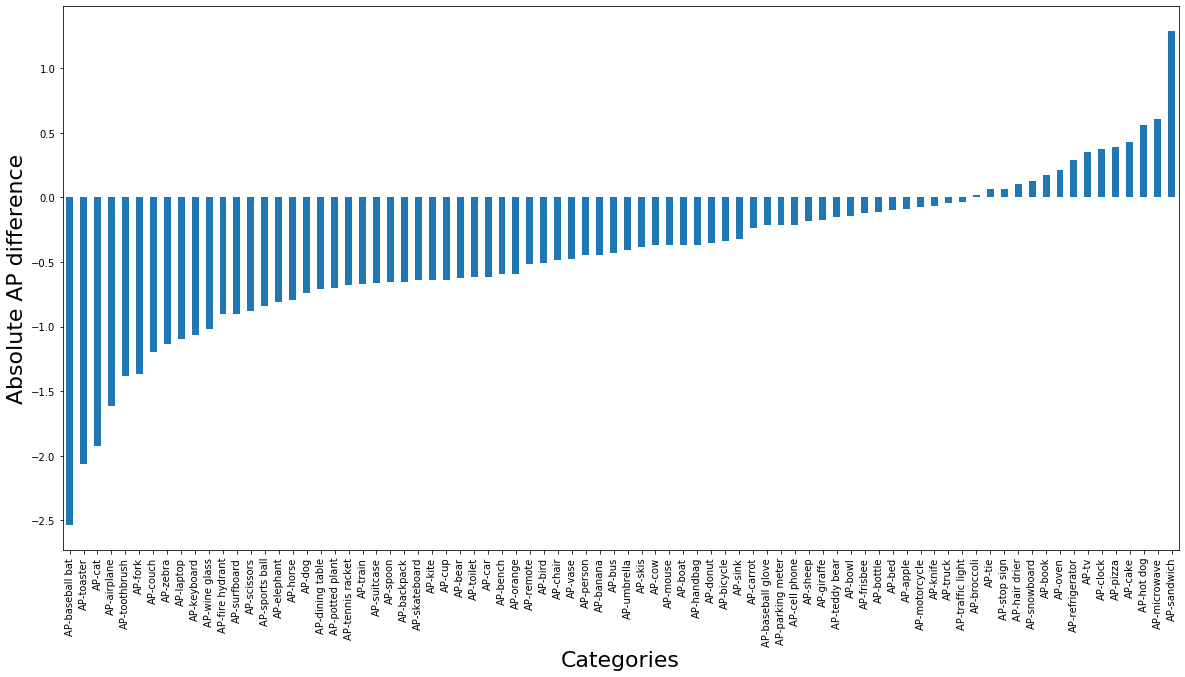

In [53]:
# Comparison by class values
import matplotlib.pyplot as plt
h = diffs[class_ap_metrics].sort_values().plot.bar(figsize=(20,10))
plt.ylabel('Absolute AP difference', fontsize=22)
plt.xlabel('Categories', fontsize=22)


Text(0.5, 0, 'Metric')

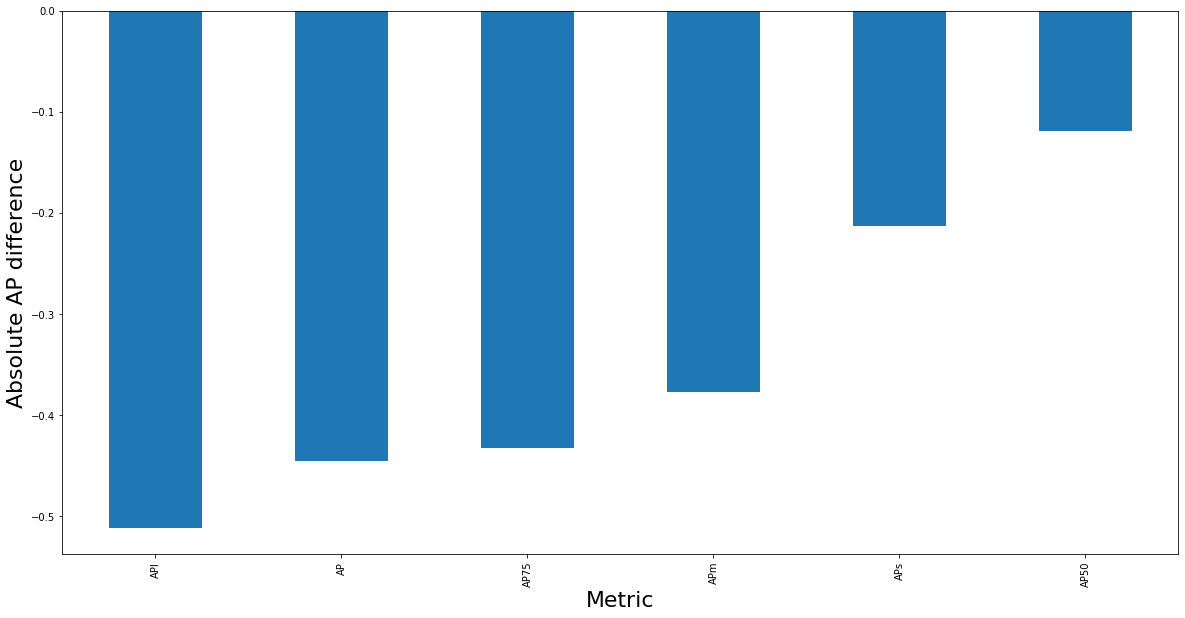

In [54]:
# Comparison by overall values
import matplotlib.pyplot as plt
h = diffs[summary_ap_metrics].sort_values().plot.bar(figsize=(20,10))
plt.ylabel('Absolute AP difference', fontsize=22)
plt.xlabel('Metric', fontsize=22)


Text(0.5, 0, 'Categories')

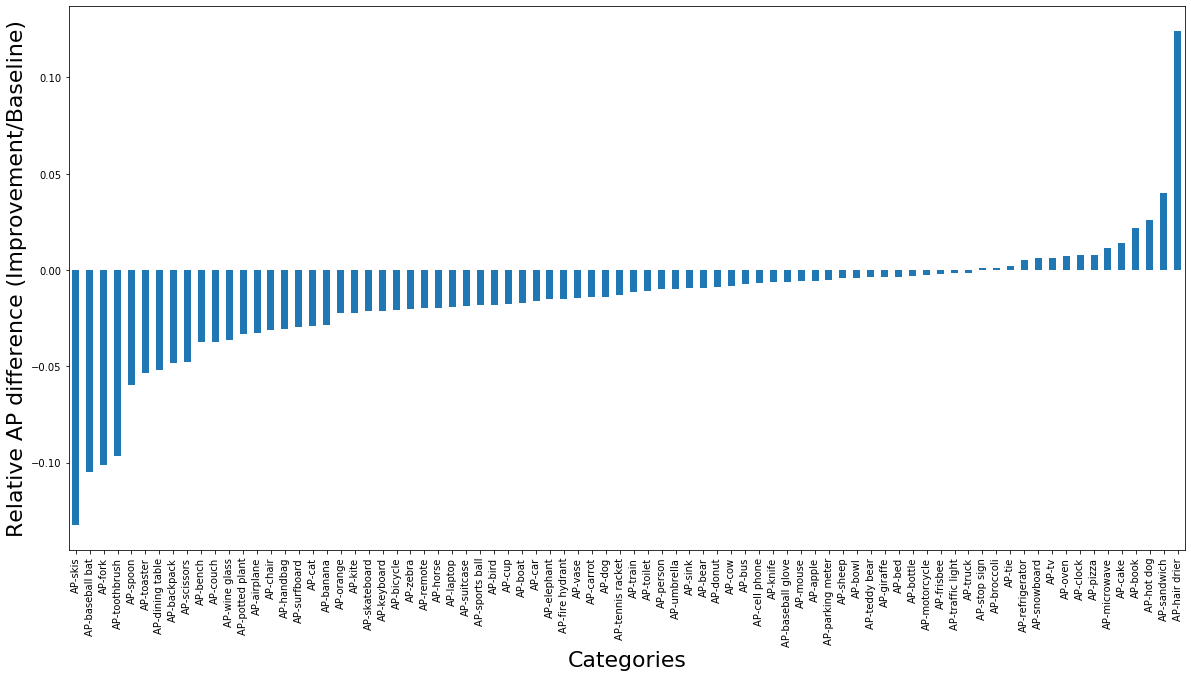

In [55]:
# Comparison by class values
import matplotlib.pyplot as plt
rel_dif = (our_ap[class_ap_metrics] - baseline_ap[class_ap_metrics]) / baseline_ap[class_ap_metrics]
h = (rel_dif).sort_values().plot.bar(figsize=(20,10), bottom=0)
plt.ylabel('Relative AP difference (Improvement/Baseline)', fontsize=22)
plt.xlabel('Categories', fontsize=22)


Text(0.5, 0, 'Categories')

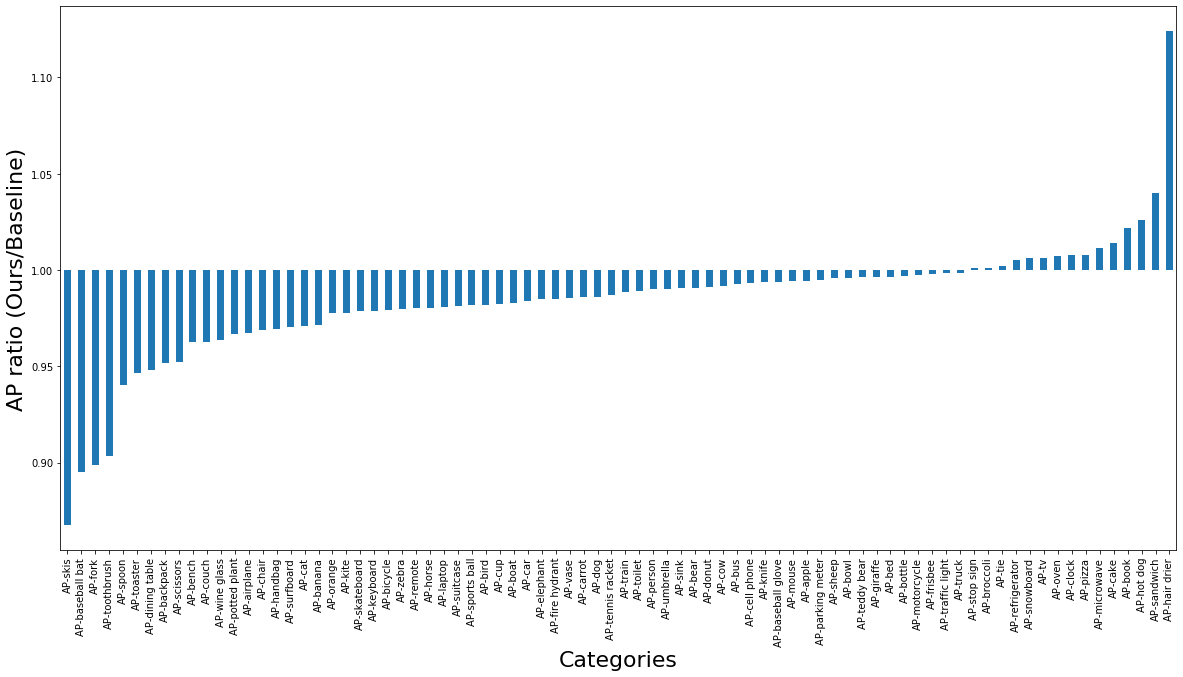

In [56]:
# Comparison by class values
import matplotlib.pyplot as plt
bottom = 1
ratio = our_ap[class_ap_metrics] / baseline_ap[class_ap_metrics]
h = (ratio - bottom).sort_values().plot.bar(figsize=(20,10), bottom=bottom)
plt.ylabel('AP ratio (Ours/Baseline)', fontsize=22)
plt.xlabel('Categories', fontsize=22)


In [57]:
our_ap / baseline_ap

AP               0.987206
AP50             0.997780
AP75             0.988540
APs              0.986826
APm              0.989868
                   ...   
AP-vase          0.985669
AP-scissors      0.952415
AP-teddy bear    0.996345
AP-hair drier    1.124031
AP-toothbrush    0.903317
Length: 86, dtype: float64

In [58]:
melted_subset = df_sorted[df_sorted['task_name'].apply(lambda x: x in ['segm-pred_masks'])]
# melted_subset = melted_subset[melted_subset['itr'].astype(int) >= 36000]
melted_subset = melted_subset[melted_subset.apply(lambda x: int(x['itr']) == 0, axis=1)]
# melted_subset = melted_subset[melted_subset['DATASETS-TEST'].apply(lambda x: 'coco_2017_val' in x)]
dftbl = melted_subset.pivot(index=cfg_cols + ['itr'], values=stat_cols, columns=['task_name'])


In [59]:
dftbl

AP  \
task_name                                                                                                                                                                                                                          segm-pred_masks   
MODEL-ROI_HEADS-NAME MODEL-ROI_MASK_HEAD-INIT_ACTIVATED_MASK_HEAD MODEL-ROI_MASK_HEAD-N_MASKS_PER_ROI DATALOADER-SAMPLER_TRAIN               DATALOADER-REPEAT_THRESHOLD SOLVER-IMS_PER_BATCH SOLVER-MAX_ITER GLOBAL-NOOP SEED itr                   
MultiROIHeadsAPD     custom                                       1                                   GeneralizedRepeatFactorTrainingSampler 0.01                        8                    100000          False        1   0          7.856149   
                                                                                                                                             1.00                        4                    16              True         1   0          6.475362   
                                                                                                      TrainingSampler                        0.00                        8                    100000          False        1   0          6.962647   
                                                                                                                                             0.02                        8                    100000          False       -1   0          7.345143   
                                                                                                                                             1.00                        8                    100000          False        1   0          7.781284   
                                                                  2                                   GeneralizedRepeatFactorTrainingSampler 0.01                        8                    100000          False        1   0         34.335903   
                     standard                                     1                                   GeneralizedRepeatFactorTrainingSampler 0.01                        8                    100000          False        1   0         34.337177   
                                                                                                      TrainingSampler                        0.00                        8                    100000          False        1   0         34.340163   
StandardROIHeads     standard                                     1                                   GeneralizedRepeatFactorTrainingSampler 0.10                        8                    100000          False       -1   0         34.334759   
                                                                                                      TrainingSampler                        0.00                        8                    100000          False        1   0         34.340551   
                                                                                                                                             1.00                        8                    100000          False       -1   0         34.333135   

                                                                                                                                                                                                                                              AP50  \
task_name                                                                                                                                                                                                                          segm-pred_masks   
MODEL-ROI_HEADS-NAME MODEL-ROI_MASK_HEAD-INIT_ACTIVATED_MASK_HEAD MODEL-ROI_MASK_HEAD-N_MASKS_PER_ROI DATALOADER-SAMPLER_TRAIN               DATALOADER-REPEAT_THRESHOLD SOLVER-IMS_PER_BATCH SOLVER-MAX_ITER GLOBAL-NOOP SEED itr                   
MultiROIHeadsAPD     custom                              

In [61]:
dftbl_smallT = dftbl_small

In [62]:
dftbl_smallT[dftbl_smallT['DATASETS-TEST'] == 'coco_2017_train']

KeyError: 'DATASETS-TEST'

In [ ]:
dftbl_smallT.columns()

In [ ]:
multiind_filt = ['coco_2017_train', slice(None), slice(None), slice(None), slice(None), slice(None), slice(None), 64000]
dftbl_small.T.index.get_locs(multiind_filt)


In [ ]:
dftbl.to_excel('/tmp/pivottable.xls')

In [ ]:
for c in dftbl.columns:
    print(dftbl[c].argmax(), dftbl[c].max())

In [ ]:
dftbl.to_csv('/tmp/pivottable.csv')

In [ ]:
def highlight_max(data, color='yellow'):
    '''
    highlight the maximum in a Series or DataFrame
    '''
    attr = 'background-color: {}'.format(color)
    #remove % and cast to float
    data = data.replace('%','', regex=True).astype(float)
    if data.ndim == 1:  # Series from .apply(axis=0) or axis=1
        is_max = data == data.max()
        return [attr if v else '' for v in is_max]
    else:  # from .apply(axis=None)
        is_max = data == data.max().max()
        return pd.DataFrame(np.where(is_max, attr, ''),
                            index=data.index, columns=data.columns)
highlight_max(dftbl)

In [ ]:
df

In [ ]:
print('Starting visualizations')
df_tmp = df_filt
df_tmp.itr = df_tmp.itr.apply(str)
output_file("filename.html")
panels = []
x_super_name = 'uniqueid'
x_sub_name = 'itr'
x_sub_unique = sorted(list(df_tmp[x_sub_name].unique()), key=lambda x: int(x))
x_super_unique = sorted(list(df_tmp[x_super_name].unique()))
x = [(x1, x2) for x1 in x_super_unique for x2 in x_sub_unique]
factor_range = FactorRange(*x)
palette = palettes.cividis(len(x_sub_unique))
cmap = palette if len(x_sub_unique) <= len(palette) else Turbo256
panels = []
for split in df_tmp.split.unique():
    df_tab = df_tmp
    df_tab = df_tab[df_tab.split == split]
    tab_name = split
    row_ps = []
    for y_name in ['AP']:  # , 'AP50', 'AP75', 'APm', 'APl']:
        col_ps = []
        for taskname in df_tmp.task_name.unique():
            title = f"{taskname}: {x_super_name} {y_name} by {x_sub_name}"
            df_vis = df_tab[df_tab.task_name == taskname]
            if len(df_vis) == 0:
                p = get_blank_figure(title=title)
            else:
                colors = [cmap[x_sub_unique.index(x_)] for x_ in df_vis[x_sub_name]]
                df_vis_as_dict = {
                    x_sub_name: df_vis[x_sub_name].tolist(),
                    x_super_name: df_vis[x_super_name].tolist(),
                    y_name: df_vis[y_name].tolist(),
                    'colors': colors,
                }
                x = [(x1, x2) for x1, x2 in
                     zip(df_vis_as_dict[x_super_name], df_vis_as_dict[x_sub_name])]
                if not len(x) == len(list(set(x))):
                    for vals in list(set(x)):
                        n_instances_of_this_key = sum([i for i, x in enumerate(x) if x == vals])
                        if n_instances_of_this_key > 1:
                            print(n_instances_of_this_key)
                            print('')
                assert len(x) == len(list(set(x)))
                p = grouped_bar(df_vis_as_dict, x_super_name=x_super_name,
                                x_sub_name=x_sub_name,
                                y_name=y_name, title=title, factor_range=factor_range)
            col_ps.append(p)
        row_ps.append(column(*col_ps))
    panel = Panel(child=row(*row_ps), title=tab_name)
    panels.append(panel)
#     export_png(panel, filename=f"{tab_name}.png")
tabs = Tabs(tabs=panels)
show(tabs)
